<a href="https://colab.research.google.com/github/ashishpatel26/Shapelet-time-Series-Classification/blob/main/Time_Series_Classification_Shaplet_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tslearn

     |████████████████████████████████| 798kB 8.5MB/s 


In [3]:
import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [4]:
# Set seed for determinism
numpy.random.seed(0)

In [5]:
# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

In [15]:
# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

In [21]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

In [24]:
help(grabocka_params_to_shapelet_size_dict)

Help on function grabocka_params_to_shapelet_size_dict in module tslearn.shapelets.shapelets:

grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_classes, l, r)
    Compute number and length of shapelets.
    
     This function uses the heuristic from [1]_.
    
    Parameters
    ----------
    n_ts: int
        Number of time series in the dataset
    ts_sz: int
        Length of time series in the dataset
    n_classes: int
        Number of classes in the dataset
    l: float
        Fraction of the length of time series to be used for base shapelet
        length
    r: int
        Number of different shapelet lengths to use
    
    Returns
    -------
    dict
        Dictionary giving, for each shapelet length, the number of such
        shapelets to be generated
    
    Examples
    --------
    >>> d = grabocka_params_to_shapelet_size_dict(
    ...         n_ts=100, ts_sz=100, n_classes=3, l=0.1, r=2)
    >>> keys = sorted(d.keys())
    >>> print(keys)
    [10, 20]
    >>

In [23]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)
print(shapelet_sizes)

{27: 4}


In [27]:
# Define the model using parameters provided by the authors (except that we use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes, 
                            optimizer=tf.optimizers.Adam(.01), 
                            batch_size=16, 
                            weight_regularizer=.01, 
                            max_iter=200, 
                            random_state=42,
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [28]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 1.4207 - categorical_accuracy: 0.3415 - categorical_crossentropy: 1.3858
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3844 - categorical_accuracy: 0.3322 - categorical_crossentropy: 1.3539
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3597 - categorical_accuracy: 0.3990 - categorical_crossentropy: 1.3322
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3344 - categorical_accuracy: 0.5362 - categorical_crossentropy: 1.3082
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3013 - categorical_accuracy: 0.5515 - categorical_crossentropy: 1.2746
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2720 - categorical_accuracy: 0.5842 - categorical_crossentropy: 1.2436
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2025 - categorical_accuracy: 0.6403 - categorical_crossentropy:

LearningShapelets(batch_size=16, max_iter=200, max_size=None,
                  n_shapelets_per_size={27: 4},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7b6aad8d50>,
                  random_state=42, scale=False, shapelet_length=0.15,
                  total_lengths=3, verbose=1, weight_regularizer=0.01)

In [29]:
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

7/7 [==============================] - 0s 2ms/step
Correct classification rate: 1.0


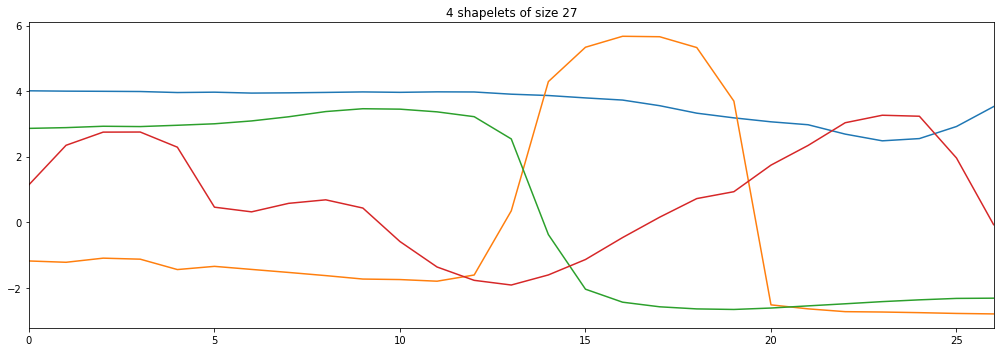

In [32]:
# Plot the different discovered shapelets
plt.figure(figsize=(14,5))
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

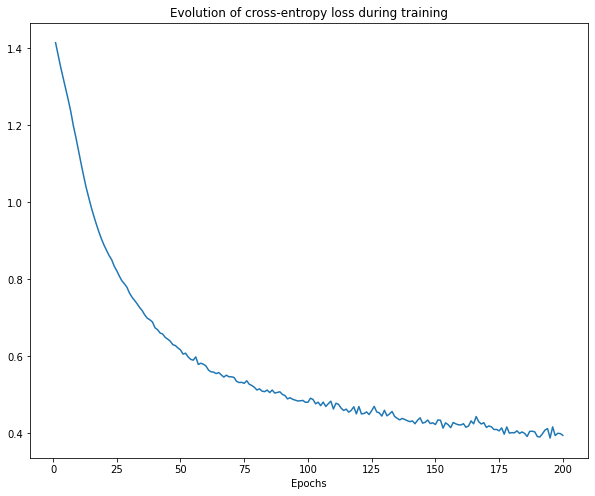

In [34]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure(figsize=(10,8))
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()